In [1]:
import pandas as pd
import torch
import sklearn
import numpy as np

In [2]:

import transformers

c:\Users\robin\anaconda3\envs\dnabert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.empty_cache()

In [4]:
modelpath = "zhihan1996/DNABERT-2-117M"
df = pd.read_csv("./sample_data/esp_decoded.csv")

print(df.info())

print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56888 entries, 0 to 56887
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seq     56888 non-null  object 
 1   y       56888 non-null  float64
dtypes: float64(1), object(1)
memory usage: 889.0+ KB
None
                     seq         y
0  AAAAAAAAACTCCAAAACCCT  0.093147
1  AAAAAACAACAAGAAGCACAA  0.064951
2  AAAAAACACAAGCAAGACCGT  0.061797
3  AAAAAACAGATGCCACCTGTG  0.057246
4  AAAAAACCCGTAGATAGCCTC  0.067596


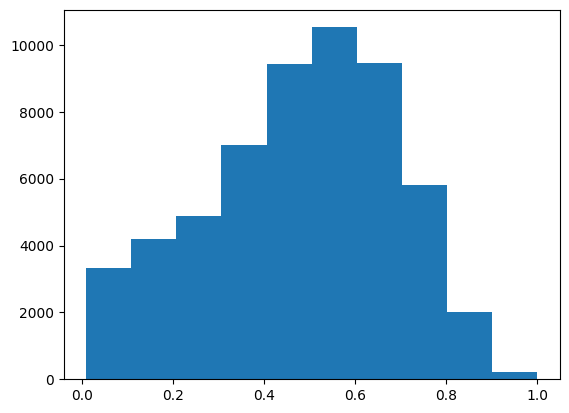

In [5]:
import matplotlib.pyplot as plt

#plot label distribution
plt.hist(df['y'])
plt.show()

In [6]:
import datasets

#turn df into a dataset
raw_dataset = datasets.Dataset.from_pandas(df)

In [7]:
#raw_dataset = raw_dataset.select(range(int(1300 * 1.2)))

print(raw_dataset)

Dataset({
    features: ['seq', 'y'],
    num_rows: 56888
})


In [8]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
        modelpath,
        
        model_max_length=100,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )

In [9]:
from transformers import DataCollatorWithPadding

def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch")

#print(output)
print(tokenized_dataset)

Map: 100%|██████████| 56888/56888 [00:01<00:00, 37448.43 examples/s]

Dataset({
    features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 56888
})


In [10]:
#split into train and validation set
tokenized_datasets = tokenized_dataset.train_test_split(test_size=0.2)

In [11]:
print(tokenized_datasets)

tokenized_datasets = tokenized_datasets.remove_columns(["seq"])
tokenized_datasets = tokenized_datasets.rename_column("y", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names


DatasetDict({
    train: Dataset({
        features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45510
    })
    test: Dataset({
        features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11378
    })
})


['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [12]:
from torch.utils.data import DataLoader

batch_size = 128

print(tokenizer.pad_token_id)
print(tokenizer.model_max_length)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding="longest", max_length=tokenizer.model_max_length)




3
100


In [17]:
# train_dataloader = DataLoader(
#     tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
# )
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)

In [14]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    modelpath,
    cache_dir=None,
    num_labels=1,
    trust_remote_code=True,
    ignore_mismatched_sizes=True
)

model.cuda()

C:\Users\robin/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\25abaf0bd247444fcfa837109f12088114898d98\bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_feat

In [15]:
# for batch in train_dataloader:
#     print(batch['labels'][0])
#     break
# print({k: v.shape for k, v in batch.items()})

In [16]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    logits = logits[0]

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

In [16]:
from transformers import Trainer, TrainingArguments

# Specifiy the arguments for the trainer  
training_args = TrainingArguments(
    output_dir ='./results',          
    num_train_epochs = 10,     
    per_device_train_batch_size = 128,   
    per_device_eval_batch_size = 32,   
    weight_decay = 0.01,               
    learning_rate = 3e-5,
    logging_dir = './logs',
    logging_steps = 10,        
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',  
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
) 


# Call the Trainer
trainer = Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = tokenized_datasets["train"],         
    eval_dataset = tokenized_datasets["test"],          
    compute_metrics = compute_metrics,
    data_collator = data_collator, 
)


# Train the model
trainer.train()

# Call the summary
trainer.evaluate()

c:\Users\robin\anaconda3\envs\dnabert\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 10/3560 [00:47<4:49:17,  4.89s/it]

{'loss': 0.1006, 'learning_rate': 2.9915730337078653e-05, 'epoch': 0.03}


  1%|          | 20/3560 [01:36<4:47:09,  4.87s/it]

{'loss': 0.0458, 'learning_rate': 2.9831460674157305e-05, 'epoch': 0.06}


  1%|          | 30/3560 [02:24<4:40:44,  4.77s/it]

{'loss': 0.0481, 'learning_rate': 2.9747191011235957e-05, 'epoch': 0.08}


  1%|          | 40/3560 [03:12<4:39:25,  4.76s/it]

{'loss': 0.0501, 'learning_rate': 2.9662921348314606e-05, 'epoch': 0.11}


  1%|▏         | 50/3560 [04:00<4:41:45,  4.82s/it]

{'loss': 0.0419, 'learning_rate': 2.9578651685393258e-05, 'epoch': 0.14}


  2%|▏         | 60/3560 [04:48<4:41:52,  4.83s/it]

{'loss': 0.0423, 'learning_rate': 2.949438202247191e-05, 'epoch': 0.17}


  2%|▏         | 70/3560 [05:38<4:48:57,  4.97s/it]

{'loss': 0.0416, 'learning_rate': 2.9410112359550562e-05, 'epoch': 0.2}


  2%|▏         | 80/3560 [06:28<4:48:59,  4.98s/it]

{'loss': 0.0423, 'learning_rate': 2.932584269662921e-05, 'epoch': 0.22}


  3%|▎         | 90/3560 [07:18<4:48:26,  4.99s/it]

{'loss': 0.0457, 'learning_rate': 2.9241573033707867e-05, 'epoch': 0.25}


  3%|▎         | 100/3560 [08:07<4:39:03,  4.84s/it]

{'loss': 0.0456, 'learning_rate': 2.915730337078652e-05, 'epoch': 0.28}


  3%|▎         | 110/3560 [08:56<4:50:40,  5.06s/it]

{'loss': 0.0478, 'learning_rate': 2.9073033707865168e-05, 'epoch': 0.31}


  3%|▎         | 120/3560 [09:46<4:40:35,  4.89s/it]

{'loss': 0.0443, 'learning_rate': 2.8988764044943823e-05, 'epoch': 0.34}


  4%|▎         | 130/3560 [10:34<4:38:21,  4.87s/it]

{'loss': 0.0421, 'learning_rate': 2.8904494382022472e-05, 'epoch': 0.37}


  4%|▍         | 140/3560 [11:24<4:41:09,  4.93s/it]

{'loss': 0.0465, 'learning_rate': 2.8820224719101124e-05, 'epoch': 0.39}


  4%|▍         | 150/3560 [12:13<4:38:34,  4.90s/it]

{'loss': 0.0428, 'learning_rate': 2.8735955056179776e-05, 'epoch': 0.42}


  4%|▍         | 160/3560 [13:02<4:38:10,  4.91s/it]

{'loss': 0.0408, 'learning_rate': 2.865168539325843e-05, 'epoch': 0.45}


  5%|▍         | 170/3560 [13:50<4:35:00,  4.87s/it]

{'loss': 0.0417, 'learning_rate': 2.856741573033708e-05, 'epoch': 0.48}


  5%|▌         | 180/3560 [14:39<4:31:39,  4.82s/it]

{'loss': 0.0442, 'learning_rate': 2.848314606741573e-05, 'epoch': 0.51}


  5%|▌         | 190/3560 [15:28<4:34:18,  4.88s/it]

{'loss': 0.044, 'learning_rate': 2.8398876404494385e-05, 'epoch': 0.53}


  6%|▌         | 200/3560 [16:17<4:35:53,  4.93s/it]

{'loss': 0.0421, 'learning_rate': 2.8314606741573034e-05, 'epoch': 0.56}


  6%|▌         | 210/3560 [17:07<4:35:53,  4.94s/it]

{'loss': 0.0407, 'learning_rate': 2.8230337078651686e-05, 'epoch': 0.59}


  6%|▌         | 220/3560 [17:56<4:29:48,  4.85s/it]

{'loss': 0.0452, 'learning_rate': 2.8146067415730338e-05, 'epoch': 0.62}


  6%|▋         | 230/3560 [18:44<4:27:45,  4.82s/it]

{'loss': 0.0437, 'learning_rate': 2.806179775280899e-05, 'epoch': 0.65}


  7%|▋         | 240/3560 [19:33<4:26:08,  4.81s/it]

{'loss': 0.0428, 'learning_rate': 2.797752808988764e-05, 'epoch': 0.67}


  7%|▋         | 250/3560 [20:22<4:30:20,  4.90s/it]

{'loss': 0.0439, 'learning_rate': 2.7893258426966294e-05, 'epoch': 0.7}


  7%|▋         | 260/3560 [21:11<4:31:21,  4.93s/it]

{'loss': 0.0435, 'learning_rate': 2.7808988764044946e-05, 'epoch': 0.73}


  8%|▊         | 270/3560 [22:00<4:27:13,  4.87s/it]

{'loss': 0.0412, 'learning_rate': 2.7724719101123595e-05, 'epoch': 0.76}


  8%|▊         | 280/3560 [22:49<4:25:14,  4.85s/it]

{'loss': 0.0426, 'learning_rate': 2.7640449438202247e-05, 'epoch': 0.79}


  8%|▊         | 290/3560 [23:38<4:30:34,  4.96s/it]

{'loss': 0.0417, 'learning_rate': 2.75561797752809e-05, 'epoch': 0.81}


  8%|▊         | 300/3560 [24:27<4:24:43,  4.87s/it]

{'loss': 0.044, 'learning_rate': 2.7471910112359552e-05, 'epoch': 0.84}


  9%|▊         | 310/3560 [25:16<4:27:09,  4.93s/it]

{'loss': 0.0436, 'learning_rate': 2.73876404494382e-05, 'epoch': 0.87}


  9%|▉         | 320/3560 [26:05<4:24:19,  4.89s/it]

{'loss': 0.0427, 'learning_rate': 2.7303370786516856e-05, 'epoch': 0.9}


  9%|▉         | 330/3560 [26:54<4:22:47,  4.88s/it]

{'loss': 0.0419, 'learning_rate': 2.7219101123595508e-05, 'epoch': 0.93}


 10%|▉         | 340/3560 [27:43<4:22:22,  4.89s/it]

{'loss': 0.0429, 'learning_rate': 2.7134831460674157e-05, 'epoch': 0.96}


 10%|▉         | 350/3560 [28:32<4:23:25,  4.92s/it]

{'loss': 0.0439, 'learning_rate': 2.7050561797752812e-05, 'epoch': 0.98}


                                                    
 10%|█         | 356/3560 [30:27<3:27:06,  3.88s/it]

{'eval_loss': 0.04298075661063194, 'eval_mse': 0.04298075661063194, 'eval_rmse': 0.2073180079460144, 'eval_mae': 0.17021974921226501, 'eval_r2': -0.006617452792863077, 'eval_runtime': 89.0378, 'eval_samples_per_second': 127.788, 'eval_steps_per_second': 3.998, 'epoch': 1.0}


 10%|█         | 360/3560 [31:15<14:40:04, 16.50s/it]

{'loss': 0.0424, 'learning_rate': 2.696629213483146e-05, 'epoch': 1.01}


 10%|█         | 370/3560 [31:57<4:06:37,  4.64s/it] 

{'loss': 0.0422, 'learning_rate': 2.6882022471910113e-05, 'epoch': 1.04}


 11%|█         | 380/3560 [32:40<3:46:04,  4.27s/it]

{'loss': 0.0436, 'learning_rate': 2.6797752808988762e-05, 'epoch': 1.07}


 11%|█         | 390/3560 [33:23<3:48:03,  4.32s/it]

{'loss': 0.044, 'learning_rate': 2.6713483146067418e-05, 'epoch': 1.1}


 11%|█         | 400/3560 [34:04<3:43:23,  4.24s/it]

{'loss': 0.0423, 'learning_rate': 2.6629213483146066e-05, 'epoch': 1.12}


 12%|█▏        | 410/3560 [34:45<3:38:34,  4.16s/it]

{'loss': 0.0436, 'learning_rate': 2.654494382022472e-05, 'epoch': 1.15}


 12%|█▏        | 420/3560 [35:24<3:22:23,  3.87s/it]

{'loss': 0.0397, 'learning_rate': 2.6460674157303374e-05, 'epoch': 1.18}


 12%|█▏        | 430/3560 [35:59<2:55:51,  3.37s/it]

{'loss': 0.0422, 'learning_rate': 2.6376404494382023e-05, 'epoch': 1.21}


 12%|█▏        | 440/3560 [36:38<3:24:09,  3.93s/it]

{'loss': 0.0421, 'learning_rate': 2.6292134831460675e-05, 'epoch': 1.24}


 13%|█▎        | 450/3560 [37:18<3:11:05,  3.69s/it]

{'loss': 0.0426, 'learning_rate': 2.6207865168539327e-05, 'epoch': 1.26}


 13%|█▎        | 460/3560 [37:59<3:33:02,  4.12s/it]

{'loss': 0.0423, 'learning_rate': 2.612359550561798e-05, 'epoch': 1.29}


 13%|█▎        | 470/3560 [38:38<3:22:14,  3.93s/it]

{'loss': 0.0441, 'learning_rate': 2.6039325842696628e-05, 'epoch': 1.32}


 13%|█▎        | 480/3560 [39:25<3:59:31,  4.67s/it]

{'loss': 0.0421, 'learning_rate': 2.595505617977528e-05, 'epoch': 1.35}


 14%|█▍        | 490/3560 [40:09<3:49:13,  4.48s/it]

{'loss': 0.0449, 'learning_rate': 2.5870786516853936e-05, 'epoch': 1.38}


 14%|█▍        | 500/3560 [40:52<3:37:12,  4.26s/it]

{'loss': 0.0407, 'learning_rate': 2.5786516853932585e-05, 'epoch': 1.4}


 14%|█▍        | 510/3560 [41:37<3:52:02,  4.56s/it]

{'loss': 0.0471, 'learning_rate': 2.5702247191011237e-05, 'epoch': 1.43}


 15%|█▍        | 520/3560 [42:18<3:34:50,  4.24s/it]

{'loss': 0.0447, 'learning_rate': 2.561797752808989e-05, 'epoch': 1.46}


 15%|█▍        | 530/3560 [42:58<3:34:48,  4.25s/it]

{'loss': 0.0443, 'learning_rate': 2.553370786516854e-05, 'epoch': 1.49}


 15%|█▌        | 540/3560 [43:42<3:32:03,  4.21s/it]

{'loss': 0.0418, 'learning_rate': 2.544943820224719e-05, 'epoch': 1.52}


 15%|█▌        | 550/3560 [44:22<3:08:55,  3.77s/it]

{'loss': 0.0435, 'learning_rate': 2.5365168539325845e-05, 'epoch': 1.54}


 16%|█▌        | 560/3560 [45:04<3:21:30,  4.03s/it]

{'loss': 0.0435, 'learning_rate': 2.5280898876404494e-05, 'epoch': 1.57}


 16%|█▌        | 570/3560 [45:46<3:24:02,  4.09s/it]

{'loss': 0.0434, 'learning_rate': 2.5196629213483146e-05, 'epoch': 1.6}


 16%|█▋        | 580/3560 [46:26<3:12:49,  3.88s/it]

{'loss': 0.0425, 'learning_rate': 2.51123595505618e-05, 'epoch': 1.63}


 17%|█▋        | 590/3560 [47:04<3:00:40,  3.65s/it]

{'loss': 0.0431, 'learning_rate': 2.502808988764045e-05, 'epoch': 1.66}


 17%|█▋        | 600/3560 [47:44<3:15:10,  3.96s/it]

{'loss': 0.0435, 'learning_rate': 2.4943820224719103e-05, 'epoch': 1.69}


 17%|█▋        | 610/3560 [48:22<2:56:59,  3.60s/it]

{'loss': 0.0408, 'learning_rate': 2.485955056179775e-05, 'epoch': 1.71}


 17%|█▋        | 620/3560 [49:04<3:30:07,  4.29s/it]

{'loss': 0.0426, 'learning_rate': 2.4775280898876407e-05, 'epoch': 1.74}


 18%|█▊        | 630/3560 [49:43<3:02:40,  3.74s/it]

{'loss': 0.0431, 'learning_rate': 2.4691011235955056e-05, 'epoch': 1.77}


 18%|█▊        | 640/3560 [50:26<3:26:57,  4.25s/it]

{'loss': 0.0451, 'learning_rate': 2.4606741573033708e-05, 'epoch': 1.8}


 18%|█▊        | 650/3560 [51:06<3:19:25,  4.11s/it]

{'loss': 0.0443, 'learning_rate': 2.4522471910112363e-05, 'epoch': 1.83}


 19%|█▊        | 660/3560 [51:49<3:18:07,  4.10s/it]

{'loss': 0.0438, 'learning_rate': 2.4438202247191012e-05, 'epoch': 1.85}


 19%|█▉        | 670/3560 [52:28<3:16:03,  4.07s/it]

{'loss': 0.0429, 'learning_rate': 2.4353932584269664e-05, 'epoch': 1.88}


 19%|█▉        | 680/3560 [53:06<3:08:25,  3.93s/it]

{'loss': 0.0416, 'learning_rate': 2.4269662921348313e-05, 'epoch': 1.91}


 19%|█▉        | 690/3560 [53:50<3:32:19,  4.44s/it]

{'loss': 0.044, 'learning_rate': 2.418539325842697e-05, 'epoch': 1.94}


 20%|█▉        | 700/3560 [54:32<3:16:54,  4.13s/it]

{'loss': 0.0447, 'learning_rate': 2.4101123595505617e-05, 'epoch': 1.97}


 20%|█▉        | 710/3560 [55:14<3:21:04,  4.23s/it]

{'loss': 0.0428, 'learning_rate': 2.401685393258427e-05, 'epoch': 1.99}


                                                    
 20%|██        | 712/3560 [56:18<3:18:37,  4.18s/it]

{'eval_loss': 0.04272029176354408, 'eval_mse': 0.04272029176354408, 'eval_rmse': 0.20668888092041016, 'eval_mae': 0.17065316438674927, 'eval_r2': -0.0005173114773204812, 'eval_runtime': 56.842, 'eval_samples_per_second': 200.169, 'eval_steps_per_second': 6.263, 'epoch': 2.0}


 20%|██        | 720/3560 [56:53<4:21:49,  5.53s/it] 

{'loss': 0.0426, 'learning_rate': 2.393258426966292e-05, 'epoch': 2.02}


 21%|██        | 730/3560 [57:34<3:19:41,  4.23s/it]

{'loss': 0.0464, 'learning_rate': 2.3848314606741574e-05, 'epoch': 2.05}


 21%|██        | 740/3560 [58:15<3:14:35,  4.14s/it]

{'loss': 0.0428, 'learning_rate': 2.3764044943820226e-05, 'epoch': 2.08}


 21%|██        | 750/3560 [58:53<3:06:03,  3.97s/it]

{'loss': 0.0416, 'learning_rate': 2.3679775280898878e-05, 'epoch': 2.11}


 21%|██▏       | 760/3560 [59:37<3:27:53,  4.45s/it]

{'loss': 0.0429, 'learning_rate': 2.359550561797753e-05, 'epoch': 2.13}


 22%|██▏       | 770/3560 [1:00:21<3:22:35,  4.36s/it]

{'loss': 0.042, 'learning_rate': 2.351123595505618e-05, 'epoch': 2.16}


 22%|██▏       | 780/3560 [1:01:00<3:02:25,  3.94s/it]

{'loss': 0.0412, 'learning_rate': 2.342696629213483e-05, 'epoch': 2.19}


 22%|██▏       | 790/3560 [1:01:39<3:07:24,  4.06s/it]

{'loss': 0.0457, 'learning_rate': 2.3342696629213483e-05, 'epoch': 2.22}


 22%|██▏       | 800/3560 [1:02:20<3:04:52,  4.02s/it]

{'loss': 0.0423, 'learning_rate': 2.3258426966292135e-05, 'epoch': 2.25}


 23%|██▎       | 810/3560 [1:03:02<3:11:50,  4.19s/it]

{'loss': 0.0425, 'learning_rate': 2.3174157303370788e-05, 'epoch': 2.28}


 23%|██▎       | 820/3560 [1:03:43<3:15:35,  4.28s/it]

{'loss': 0.0408, 'learning_rate': 2.308988764044944e-05, 'epoch': 2.3}


 23%|██▎       | 830/3560 [1:04:25<3:11:20,  4.21s/it]

{'loss': 0.0438, 'learning_rate': 2.3005617977528092e-05, 'epoch': 2.33}


 24%|██▎       | 840/3560 [1:05:05<2:56:42,  3.90s/it]

{'loss': 0.0424, 'learning_rate': 2.292134831460674e-05, 'epoch': 2.36}


 24%|██▍       | 850/3560 [1:05:45<3:02:15,  4.04s/it]

{'loss': 0.0425, 'learning_rate': 2.2837078651685396e-05, 'epoch': 2.39}


 24%|██▍       | 860/3560 [1:06:24<2:47:39,  3.73s/it]

{'loss': 0.0436, 'learning_rate': 2.2752808988764045e-05, 'epoch': 2.42}


 24%|██▍       | 870/3560 [1:07:04<3:07:09,  4.17s/it]

{'loss': 0.0443, 'learning_rate': 2.2668539325842697e-05, 'epoch': 2.44}


 25%|██▍       | 880/3560 [1:07:43<2:45:19,  3.70s/it]

{'loss': 0.0438, 'learning_rate': 2.2584269662921346e-05, 'epoch': 2.47}


 25%|██▌       | 890/3560 [1:08:25<3:15:00,  4.38s/it]

{'loss': 0.0427, 'learning_rate': 2.25e-05, 'epoch': 2.5}


 25%|██▌       | 900/3560 [1:09:06<3:02:08,  4.11s/it]

{'loss': 0.0437, 'learning_rate': 2.2415730337078654e-05, 'epoch': 2.53}


 26%|██▌       | 910/3560 [1:09:49<3:16:13,  4.44s/it]

{'loss': 0.0406, 'learning_rate': 2.2331460674157302e-05, 'epoch': 2.56}


 26%|██▌       | 920/3560 [1:10:25<2:31:04,  3.43s/it]

{'loss': 0.0449, 'learning_rate': 2.2247191011235958e-05, 'epoch': 2.58}


 26%|██▌       | 930/3560 [1:11:07<2:58:30,  4.07s/it]

{'loss': 0.0413, 'learning_rate': 2.2162921348314607e-05, 'epoch': 2.61}


 26%|██▋       | 940/3560 [1:11:47<2:52:42,  3.96s/it]

{'loss': 0.0428, 'learning_rate': 2.207865168539326e-05, 'epoch': 2.64}


 27%|██▋       | 950/3560 [1:12:28<2:57:06,  4.07s/it]

{'loss': 0.0425, 'learning_rate': 2.199438202247191e-05, 'epoch': 2.67}


 27%|██▋       | 960/3560 [1:13:06<2:38:49,  3.67s/it]

{'loss': 0.045, 'learning_rate': 2.1910112359550563e-05, 'epoch': 2.7}


 27%|██▋       | 970/3560 [1:13:45<2:35:23,  3.60s/it]

{'loss': 0.0429, 'learning_rate': 2.1825842696629212e-05, 'epoch': 2.72}


 28%|██▊       | 980/3560 [1:14:26<3:05:13,  4.31s/it]

{'loss': 0.0434, 'learning_rate': 2.1741573033707864e-05, 'epoch': 2.75}


 28%|██▊       | 990/3560 [1:15:07<2:58:30,  4.17s/it]

{'loss': 0.0415, 'learning_rate': 2.165730337078652e-05, 'epoch': 2.78}


 28%|██▊       | 1000/3560 [1:15:50<2:54:51,  4.10s/it]

{'loss': 0.0445, 'learning_rate': 2.1573033707865168e-05, 'epoch': 2.81}


 28%|██▊       | 1010/3560 [1:16:31<3:04:39,  4.35s/it]

{'loss': 0.0419, 'learning_rate': 2.148876404494382e-05, 'epoch': 2.84}


 29%|██▊       | 1020/3560 [1:17:13<2:44:22,  3.88s/it]

{'loss': 0.0414, 'learning_rate': 2.1404494382022473e-05, 'epoch': 2.87}


 29%|██▉       | 1030/3560 [1:17:53<2:47:18,  3.97s/it]

{'loss': 0.0438, 'learning_rate': 2.1320224719101125e-05, 'epoch': 2.89}


 29%|██▉       | 1040/3560 [1:18:33<2:46:21,  3.96s/it]

{'loss': 0.0442, 'learning_rate': 2.1235955056179773e-05, 'epoch': 2.92}


 29%|██▉       | 1050/3560 [1:19:17<2:52:58,  4.13s/it]

{'loss': 0.0446, 'learning_rate': 2.115168539325843e-05, 'epoch': 2.95}


 30%|██▉       | 1060/3560 [1:19:57<2:49:54,  4.08s/it]

{'loss': 0.0417, 'learning_rate': 2.106741573033708e-05, 'epoch': 2.98}


                                                       
 30%|███       | 1068/3560 [1:21:24<2:43:34,  3.94s/it]

{'eval_loss': 0.04274708405137062, 'eval_mse': 0.04274708405137062, 'eval_rmse': 0.2067536860704422, 'eval_mae': 0.17053599655628204, 'eval_r2': -0.0011448367554038885, 'eval_runtime': 56.7238, 'eval_samples_per_second': 200.586, 'eval_steps_per_second': 6.276, 'epoch': 3.0}


 30%|███       | 1070/3560 [1:21:36<11:28:02, 16.58s/it]

{'loss': 0.0418, 'learning_rate': 2.098314606741573e-05, 'epoch': 3.01}


 30%|███       | 1080/3560 [1:22:15<2:59:09,  4.33s/it] 

{'loss': 0.0413, 'learning_rate': 2.0898876404494382e-05, 'epoch': 3.03}


 31%|███       | 1090/3560 [1:22:57<2:50:44,  4.15s/it]

{'loss': 0.0427, 'learning_rate': 2.0814606741573034e-05, 'epoch': 3.06}


 31%|███       | 1100/3560 [1:23:40<3:00:02,  4.39s/it]

{'loss': 0.0436, 'learning_rate': 2.0730337078651686e-05, 'epoch': 3.09}


 31%|███       | 1110/3560 [1:24:21<2:36:27,  3.83s/it]

{'loss': 0.0452, 'learning_rate': 2.0646067415730335e-05, 'epoch': 3.12}


 31%|███▏      | 1120/3560 [1:25:02<2:51:12,  4.21s/it]

{'loss': 0.0456, 'learning_rate': 2.056179775280899e-05, 'epoch': 3.15}


 32%|███▏      | 1130/3560 [1:25:44<2:46:48,  4.12s/it]

{'loss': 0.0432, 'learning_rate': 2.047752808988764e-05, 'epoch': 3.17}


 32%|███▏      | 1140/3560 [1:26:25<2:52:16,  4.27s/it]

{'loss': 0.0422, 'learning_rate': 2.039325842696629e-05, 'epoch': 3.2}


 32%|███▏      | 1150/3560 [1:27:06<2:37:07,  3.91s/it]

{'loss': 0.0427, 'learning_rate': 2.0308988764044947e-05, 'epoch': 3.23}


 33%|███▎      | 1160/3560 [1:27:41<2:08:39,  3.22s/it]

{'loss': 0.044, 'learning_rate': 2.0224719101123596e-05, 'epoch': 3.26}


 33%|███▎      | 1170/3560 [1:28:20<2:21:40,  3.56s/it]

{'loss': 0.0405, 'learning_rate': 2.0140449438202248e-05, 'epoch': 3.29}


 33%|███▎      | 1180/3560 [1:29:02<2:48:45,  4.25s/it]

{'loss': 0.0446, 'learning_rate': 2.0056179775280897e-05, 'epoch': 3.31}


 33%|███▎      | 1190/3560 [1:29:43<2:45:26,  4.19s/it]

{'loss': 0.0426, 'learning_rate': 1.9971910112359552e-05, 'epoch': 3.34}


 34%|███▎      | 1200/3560 [1:30:23<2:37:03,  3.99s/it]

{'loss': 0.0425, 'learning_rate': 1.98876404494382e-05, 'epoch': 3.37}


 34%|███▍      | 1210/3560 [1:31:03<2:36:29,  4.00s/it]

{'loss': 0.0456, 'learning_rate': 1.9803370786516853e-05, 'epoch': 3.4}


 34%|███▍      | 1220/3560 [1:31:43<2:40:51,  4.12s/it]

{'loss': 0.0427, 'learning_rate': 1.971910112359551e-05, 'epoch': 3.43}


 35%|███▍      | 1230/3560 [1:32:22<2:41:12,  4.15s/it]

{'loss': 0.0455, 'learning_rate': 1.9634831460674158e-05, 'epoch': 3.46}


 35%|███▍      | 1240/3560 [1:33:03<2:32:36,  3.95s/it]

{'loss': 0.0439, 'learning_rate': 1.955056179775281e-05, 'epoch': 3.48}


 35%|███▌      | 1250/3560 [1:33:40<2:16:12,  3.54s/it]

{'loss': 0.0438, 'learning_rate': 1.9466292134831462e-05, 'epoch': 3.51}


 35%|███▌      | 1260/3560 [1:34:17<2:20:54,  3.68s/it]

{'loss': 0.0436, 'learning_rate': 1.9382022471910114e-05, 'epoch': 3.54}


 36%|███▌      | 1270/3560 [1:34:55<2:39:40,  4.18s/it]

{'loss': 0.0435, 'learning_rate': 1.9297752808988763e-05, 'epoch': 3.57}


 36%|███▌      | 1280/3560 [1:35:35<2:34:03,  4.05s/it]

{'loss': 0.0422, 'learning_rate': 1.9213483146067415e-05, 'epoch': 3.6}


 36%|███▌      | 1290/3560 [1:36:11<2:29:16,  3.95s/it]

{'loss': 0.044, 'learning_rate': 1.9129213483146067e-05, 'epoch': 3.62}


 37%|███▋      | 1300/3560 [1:36:53<2:40:21,  4.26s/it]

{'loss': 0.0417, 'learning_rate': 1.904494382022472e-05, 'epoch': 3.65}


 37%|███▋      | 1310/3560 [1:37:35<2:35:50,  4.16s/it]

{'loss': 0.0408, 'learning_rate': 1.896067415730337e-05, 'epoch': 3.68}


 37%|███▋      | 1320/3560 [1:38:19<2:42:21,  4.35s/it]

{'loss': 0.0423, 'learning_rate': 1.8876404494382024e-05, 'epoch': 3.71}


 37%|███▋      | 1330/3560 [1:38:58<2:23:49,  3.87s/it]

{'loss': 0.0436, 'learning_rate': 1.8792134831460676e-05, 'epoch': 3.74}


 38%|███▊      | 1340/3560 [1:39:38<2:28:11,  4.01s/it]

{'loss': 0.0435, 'learning_rate': 1.8707865168539324e-05, 'epoch': 3.76}


 38%|███▊      | 1350/3560 [1:40:22<2:37:10,  4.27s/it]

{'loss': 0.0405, 'learning_rate': 1.862359550561798e-05, 'epoch': 3.79}


 38%|███▊      | 1360/3560 [1:41:02<2:27:43,  4.03s/it]

{'loss': 0.0437, 'learning_rate': 1.853932584269663e-05, 'epoch': 3.82}


 38%|███▊      | 1370/3560 [1:41:43<2:29:06,  4.09s/it]

{'loss': 0.0431, 'learning_rate': 1.845505617977528e-05, 'epoch': 3.85}


 39%|███▉      | 1380/3560 [1:42:24<2:42:58,  4.49s/it]

{'loss': 0.0436, 'learning_rate': 1.8370786516853933e-05, 'epoch': 3.88}


 39%|███▉      | 1390/3560 [1:43:06<2:29:03,  4.12s/it]

{'loss': 0.0424, 'learning_rate': 1.8286516853932585e-05, 'epoch': 3.9}


 39%|███▉      | 1400/3560 [1:43:46<2:22:43,  3.96s/it]

{'loss': 0.0412, 'learning_rate': 1.8202247191011237e-05, 'epoch': 3.93}


 40%|███▉      | 1410/3560 [1:44:24<2:18:00,  3.85s/it]

{'loss': 0.043, 'learning_rate': 1.8117977528089886e-05, 'epoch': 3.96}


 40%|███▉      | 1420/3560 [1:45:07<2:32:36,  4.28s/it]

{'loss': 0.0393, 'learning_rate': 1.803370786516854e-05, 'epoch': 3.99}


                                                       
 40%|████      | 1424/3560 [1:46:19<2:23:26,  4.03s/it]

{'eval_loss': 0.04269910231232643, 'eval_mse': 0.04269910231232643, 'eval_rmse': 0.20663760602474213, 'eval_mae': 0.17100583016872406, 'eval_r2': -2.1071628051316793e-05, 'eval_runtime': 56.8401, 'eval_samples_per_second': 200.176, 'eval_steps_per_second': 6.263, 'epoch': 4.0}


 40%|████      | 1430/3560 [1:46:46<4:10:29,  7.06s/it] 

{'loss': 0.0438, 'learning_rate': 1.794943820224719e-05, 'epoch': 4.02}


 40%|████      | 1440/3560 [1:47:28<2:35:57,  4.41s/it]

{'loss': 0.0443, 'learning_rate': 1.7865168539325843e-05, 'epoch': 4.04}


 41%|████      | 1450/3560 [1:48:10<2:33:40,  4.37s/it]

{'loss': 0.0444, 'learning_rate': 1.7780898876404495e-05, 'epoch': 4.07}


 41%|████      | 1460/3560 [1:48:50<2:08:58,  3.69s/it]

{'loss': 0.0397, 'learning_rate': 1.7696629213483147e-05, 'epoch': 4.1}


 41%|████▏     | 1470/3560 [1:49:30<2:21:36,  4.07s/it]

{'loss': 0.0456, 'learning_rate': 1.76123595505618e-05, 'epoch': 4.13}


 42%|████▏     | 1480/3560 [1:50:14<2:22:06,  4.10s/it]

{'loss': 0.0429, 'learning_rate': 1.7528089887640448e-05, 'epoch': 4.16}


 42%|████▏     | 1490/3560 [1:50:56<2:20:46,  4.08s/it]

{'loss': 0.0454, 'learning_rate': 1.7443820224719103e-05, 'epoch': 4.19}


 42%|████▏     | 1500/3560 [1:51:38<2:31:07,  4.40s/it]

{'loss': 0.0424, 'learning_rate': 1.7359550561797752e-05, 'epoch': 4.21}


 42%|████▏     | 1510/3560 [1:52:19<2:22:43,  4.18s/it]

{'loss': 0.041, 'learning_rate': 1.7275280898876404e-05, 'epoch': 4.24}


 43%|████▎     | 1520/3560 [1:53:04<2:32:43,  4.49s/it]

{'loss': 0.0439, 'learning_rate': 1.7191011235955056e-05, 'epoch': 4.27}


 43%|████▎     | 1530/3560 [1:53:44<2:16:35,  4.04s/it]

{'loss': 0.0416, 'learning_rate': 1.710674157303371e-05, 'epoch': 4.3}


 43%|████▎     | 1540/3560 [1:54:23<2:18:21,  4.11s/it]

{'loss': 0.043, 'learning_rate': 1.702247191011236e-05, 'epoch': 4.33}


 44%|████▎     | 1550/3560 [1:55:07<2:22:31,  4.25s/it]

{'loss': 0.0405, 'learning_rate': 1.6938202247191013e-05, 'epoch': 4.35}


 44%|████▍     | 1560/3560 [1:55:48<2:11:51,  3.96s/it]

{'loss': 0.0439, 'learning_rate': 1.6853932584269665e-05, 'epoch': 4.38}


 44%|████▍     | 1570/3560 [1:56:28<2:06:01,  3.80s/it]

{'loss': 0.0418, 'learning_rate': 1.6769662921348314e-05, 'epoch': 4.41}


 44%|████▍     | 1580/3560 [1:57:06<2:11:55,  4.00s/it]

{'loss': 0.0407, 'learning_rate': 1.6685393258426966e-05, 'epoch': 4.44}


 45%|████▍     | 1590/3560 [1:57:48<2:13:24,  4.06s/it]

{'loss': 0.0417, 'learning_rate': 1.6601123595505618e-05, 'epoch': 4.47}


 45%|████▍     | 1600/3560 [1:58:29<2:13:59,  4.10s/it]

{'loss': 0.0404, 'learning_rate': 1.651685393258427e-05, 'epoch': 4.49}


 45%|████▌     | 1610/3560 [1:59:12<2:13:07,  4.10s/it]

{'loss': 0.0465, 'learning_rate': 1.643258426966292e-05, 'epoch': 4.52}


 46%|████▌     | 1620/3560 [1:59:48<1:59:30,  3.70s/it]

{'loss': 0.0446, 'learning_rate': 1.6348314606741574e-05, 'epoch': 4.55}


 46%|████▌     | 1630/3560 [2:00:30<2:08:48,  4.00s/it]

{'loss': 0.0447, 'learning_rate': 1.6264044943820227e-05, 'epoch': 4.58}


 46%|████▌     | 1640/3560 [2:01:10<2:10:45,  4.09s/it]

{'loss': 0.0425, 'learning_rate': 1.6179775280898875e-05, 'epoch': 4.61}


 46%|████▋     | 1650/3560 [2:01:48<2:06:29,  3.97s/it]

{'loss': 0.0429, 'learning_rate': 1.609550561797753e-05, 'epoch': 4.63}


 47%|████▋     | 1660/3560 [2:02:25<1:52:32,  3.55s/it]

{'loss': 0.0452, 'learning_rate': 1.601123595505618e-05, 'epoch': 4.66}


 47%|████▋     | 1670/3560 [2:03:09<2:16:50,  4.34s/it]

{'loss': 0.0441, 'learning_rate': 1.5926966292134832e-05, 'epoch': 4.69}


 47%|████▋     | 1680/3560 [2:03:52<2:17:07,  4.38s/it]

{'loss': 0.0438, 'learning_rate': 1.5842696629213484e-05, 'epoch': 4.72}


 47%|████▋     | 1690/3560 [2:04:32<2:04:45,  4.00s/it]

{'loss': 0.0421, 'learning_rate': 1.5758426966292136e-05, 'epoch': 4.75}


 48%|████▊     | 1700/3560 [2:05:10<2:04:37,  4.02s/it]

{'loss': 0.0448, 'learning_rate': 1.5674157303370788e-05, 'epoch': 4.78}


 48%|████▊     | 1710/3560 [2:05:49<2:04:08,  4.03s/it]

{'loss': 0.0433, 'learning_rate': 1.5589887640449437e-05, 'epoch': 4.8}


 48%|████▊     | 1720/3560 [2:06:27<1:59:19,  3.89s/it]

{'loss': 0.0412, 'learning_rate': 1.5505617977528093e-05, 'epoch': 4.83}


 49%|████▊     | 1730/3560 [2:07:07<1:53:49,  3.73s/it]

{'loss': 0.0429, 'learning_rate': 1.542134831460674e-05, 'epoch': 4.86}


 49%|████▉     | 1740/3560 [2:07:47<1:58:37,  3.91s/it]

{'loss': 0.0439, 'learning_rate': 1.5337078651685393e-05, 'epoch': 4.89}


 49%|████▉     | 1750/3560 [2:08:28<1:57:26,  3.89s/it]

{'loss': 0.0416, 'learning_rate': 1.5252808988764044e-05, 'epoch': 4.92}


 49%|████▉     | 1760/3560 [2:09:07<1:50:18,  3.68s/it]

{'loss': 0.0426, 'learning_rate': 1.5168539325842698e-05, 'epoch': 4.94}


 50%|████▉     | 1770/3560 [2:09:45<1:55:27,  3.87s/it]

{'loss': 0.0417, 'learning_rate': 1.5084269662921347e-05, 'epoch': 4.97}


 50%|█████     | 1780/3560 [2:10:26<2:02:19,  4.12s/it]

{'loss': 0.042, 'learning_rate': 1.5e-05, 'epoch': 5.0}


                                                       
 50%|█████     | 1780/3560 [2:11:22<2:02:19,  4.12s/it]

{'eval_loss': 0.042764563113451004, 'eval_mse': 0.042764563113451004, 'eval_rmse': 0.20679594576358795, 'eval_mae': 0.17160002887248993, 'eval_r2': -0.0015542445828693463, 'eval_runtime': 56.1082, 'eval_samples_per_second': 202.787, 'eval_steps_per_second': 6.345, 'epoch': 5.0}


 50%|█████     | 1790/3560 [2:12:10<2:19:37,  4.73s/it] 

{'loss': 0.0416, 'learning_rate': 1.4915730337078653e-05, 'epoch': 5.03}


 51%|█████     | 1800/3560 [2:12:50<1:54:20,  3.90s/it]

{'loss': 0.0438, 'learning_rate': 1.4831460674157303e-05, 'epoch': 5.06}


 51%|█████     | 1810/3560 [2:13:33<2:00:00,  4.11s/it]

{'loss': 0.0455, 'learning_rate': 1.4747191011235955e-05, 'epoch': 5.08}


 51%|█████     | 1820/3560 [2:14:11<1:46:36,  3.68s/it]

{'loss': 0.0418, 'learning_rate': 1.4662921348314606e-05, 'epoch': 5.11}


 51%|█████▏    | 1830/3560 [2:14:52<1:59:09,  4.13s/it]

{'loss': 0.0423, 'learning_rate': 1.457865168539326e-05, 'epoch': 5.14}


 52%|█████▏    | 1840/3560 [2:15:30<1:50:49,  3.87s/it]

{'loss': 0.0426, 'learning_rate': 1.4494382022471912e-05, 'epoch': 5.17}


 52%|█████▏    | 1850/3560 [2:16:10<1:56:04,  4.07s/it]

{'loss': 0.0417, 'learning_rate': 1.4410112359550562e-05, 'epoch': 5.2}


 52%|█████▏    | 1860/3560 [2:16:52<1:59:59,  4.24s/it]

{'loss': 0.0459, 'learning_rate': 1.4325842696629214e-05, 'epoch': 5.22}


 53%|█████▎    | 1870/3560 [2:17:30<1:47:13,  3.81s/it]

{'loss': 0.0425, 'learning_rate': 1.4241573033707865e-05, 'epoch': 5.25}


 53%|█████▎    | 1880/3560 [2:18:08<1:56:53,  4.17s/it]

{'loss': 0.0412, 'learning_rate': 1.4157303370786517e-05, 'epoch': 5.28}


 53%|█████▎    | 1890/3560 [2:18:49<1:51:10,  3.99s/it]

{'loss': 0.0438, 'learning_rate': 1.4073033707865169e-05, 'epoch': 5.31}


 53%|█████▎    | 1900/3560 [2:19:26<1:30:37,  3.28s/it]

{'loss': 0.043, 'learning_rate': 1.398876404494382e-05, 'epoch': 5.34}


 54%|█████▎    | 1910/3560 [2:20:07<1:58:10,  4.30s/it]

{'loss': 0.0427, 'learning_rate': 1.3904494382022473e-05, 'epoch': 5.37}


 54%|█████▍    | 1920/3560 [2:20:46<1:45:03,  3.84s/it]

{'loss': 0.041, 'learning_rate': 1.3820224719101124e-05, 'epoch': 5.39}


 54%|█████▍    | 1930/3560 [2:21:27<1:57:45,  4.33s/it]

{'loss': 0.0417, 'learning_rate': 1.3735955056179776e-05, 'epoch': 5.42}


 54%|█████▍    | 1940/3560 [2:22:04<1:38:25,  3.65s/it]

{'loss': 0.0431, 'learning_rate': 1.3651685393258428e-05, 'epoch': 5.45}


 55%|█████▍    | 1950/3560 [2:22:47<1:56:27,  4.34s/it]

{'loss': 0.0433, 'learning_rate': 1.3567415730337078e-05, 'epoch': 5.48}


 55%|█████▌    | 1960/3560 [2:23:27<1:44:23,  3.91s/it]

{'loss': 0.0426, 'learning_rate': 1.348314606741573e-05, 'epoch': 5.51}


 55%|█████▌    | 1970/3560 [2:24:06<1:42:39,  3.87s/it]

{'loss': 0.044, 'learning_rate': 1.3398876404494381e-05, 'epoch': 5.53}


 56%|█████▌    | 1980/3560 [2:24:45<1:42:43,  3.90s/it]

{'loss': 0.0408, 'learning_rate': 1.3314606741573033e-05, 'epoch': 5.56}


 56%|█████▌    | 1990/3560 [2:25:24<1:42:52,  3.93s/it]

{'loss': 0.0439, 'learning_rate': 1.3230337078651687e-05, 'epoch': 5.59}


 56%|█████▌    | 2000/3560 [2:26:02<1:47:52,  4.15s/it]

{'loss': 0.0446, 'learning_rate': 1.3146067415730338e-05, 'epoch': 5.62}


 56%|█████▋    | 2010/3560 [2:26:40<1:24:30,  3.27s/it]

{'loss': 0.0461, 'learning_rate': 1.306179775280899e-05, 'epoch': 5.65}


 57%|█████▋    | 2020/3560 [2:27:19<1:41:14,  3.94s/it]

{'loss': 0.0446, 'learning_rate': 1.297752808988764e-05, 'epoch': 5.67}


 57%|█████▋    | 2030/3560 [2:28:01<1:41:45,  3.99s/it]

{'loss': 0.0443, 'learning_rate': 1.2893258426966292e-05, 'epoch': 5.7}


 57%|█████▋    | 2040/3560 [2:28:40<1:45:38,  4.17s/it]

{'loss': 0.0408, 'learning_rate': 1.2808988764044944e-05, 'epoch': 5.73}


 58%|█████▊    | 2050/3560 [2:29:22<1:41:45,  4.04s/it]

{'loss': 0.0421, 'learning_rate': 1.2724719101123595e-05, 'epoch': 5.76}


 58%|█████▊    | 2060/3560 [2:30:02<1:42:43,  4.11s/it]

{'loss': 0.0418, 'learning_rate': 1.2640449438202247e-05, 'epoch': 5.79}


 58%|█████▊    | 2070/3560 [2:30:40<1:34:32,  3.81s/it]

{'loss': 0.0427, 'learning_rate': 1.25561797752809e-05, 'epoch': 5.81}


 58%|█████▊    | 2080/3560 [2:31:22<1:46:18,  4.31s/it]

{'loss': 0.0422, 'learning_rate': 1.2471910112359551e-05, 'epoch': 5.84}


 59%|█████▊    | 2090/3560 [2:32:07<1:49:17,  4.46s/it]

{'loss': 0.0429, 'learning_rate': 1.2387640449438203e-05, 'epoch': 5.87}


 59%|█████▉    | 2100/3560 [2:32:45<1:31:43,  3.77s/it]

{'loss': 0.0399, 'learning_rate': 1.2303370786516854e-05, 'epoch': 5.9}


 59%|█████▉    | 2110/3560 [2:33:23<1:34:06,  3.89s/it]

{'loss': 0.0442, 'learning_rate': 1.2219101123595506e-05, 'epoch': 5.93}


 60%|█████▉    | 2120/3560 [2:34:03<1:41:32,  4.23s/it]

{'loss': 0.0419, 'learning_rate': 1.2134831460674157e-05, 'epoch': 5.96}


 60%|█████▉    | 2130/3560 [2:34:46<1:40:00,  4.20s/it]

{'loss': 0.044, 'learning_rate': 1.2050561797752809e-05, 'epoch': 5.98}


                                                       
 60%|██████    | 2136/3560 [2:36:05<1:32:35,  3.90s/it]

{'eval_loss': 0.04272164776921272, 'eval_mse': 0.04272164776921272, 'eval_rmse': 0.2066921591758728, 'eval_mae': 0.17130763828754425, 'eval_r2': -0.0005491231799361618, 'eval_runtime': 56.6702, 'eval_samples_per_second': 200.776, 'eval_steps_per_second': 6.282, 'epoch': 6.0}


 60%|██████    | 2140/3560 [2:36:24<3:59:51, 10.14s/it]

{'loss': 0.0438, 'learning_rate': 1.196629213483146e-05, 'epoch': 6.01}


 60%|██████    | 2150/3560 [2:37:06<1:43:48,  4.42s/it]

{'loss': 0.0428, 'learning_rate': 1.1882022471910113e-05, 'epoch': 6.04}


 61%|██████    | 2160/3560 [2:37:46<1:28:53,  3.81s/it]

{'loss': 0.044, 'learning_rate': 1.1797752808988765e-05, 'epoch': 6.07}


 61%|██████    | 2170/3560 [2:38:24<1:34:42,  4.09s/it]

{'loss': 0.0436, 'learning_rate': 1.1713483146067416e-05, 'epoch': 6.1}


 61%|██████    | 2180/3560 [2:39:07<1:36:14,  4.18s/it]

{'loss': 0.0385, 'learning_rate': 1.1629213483146068e-05, 'epoch': 6.12}


 62%|██████▏   | 2190/3560 [2:39:48<1:36:06,  4.21s/it]

{'loss': 0.0446, 'learning_rate': 1.154494382022472e-05, 'epoch': 6.15}


 62%|██████▏   | 2200/3560 [2:40:30<1:34:21,  4.16s/it]

{'loss': 0.0451, 'learning_rate': 1.146067415730337e-05, 'epoch': 6.18}


 62%|██████▏   | 2210/3560 [2:41:10<1:28:24,  3.93s/it]

{'loss': 0.0402, 'learning_rate': 1.1376404494382022e-05, 'epoch': 6.21}


 62%|██████▏   | 2220/3560 [2:41:49<1:22:02,  3.67s/it]

{'loss': 0.0418, 'learning_rate': 1.1292134831460673e-05, 'epoch': 6.24}


 63%|██████▎   | 2230/3560 [2:42:30<1:24:12,  3.80s/it]

{'loss': 0.0408, 'learning_rate': 1.1207865168539327e-05, 'epoch': 6.26}


 63%|██████▎   | 2240/3560 [2:43:08<1:21:34,  3.71s/it]

{'loss': 0.0445, 'learning_rate': 1.1123595505617979e-05, 'epoch': 6.29}


 63%|██████▎   | 2250/3560 [2:43:50<1:29:39,  4.11s/it]

{'loss': 0.0421, 'learning_rate': 1.103932584269663e-05, 'epoch': 6.32}


 63%|██████▎   | 2260/3560 [2:44:33<1:32:18,  4.26s/it]

{'loss': 0.0417, 'learning_rate': 1.0955056179775282e-05, 'epoch': 6.35}


 64%|██████▍   | 2270/3560 [2:45:16<1:30:56,  4.23s/it]

{'loss': 0.0423, 'learning_rate': 1.0870786516853932e-05, 'epoch': 6.38}


 64%|██████▍   | 2280/3560 [2:45:55<1:24:28,  3.96s/it]

{'loss': 0.0411, 'learning_rate': 1.0786516853932584e-05, 'epoch': 6.4}


 64%|██████▍   | 2290/3560 [2:46:35<1:24:15,  3.98s/it]

{'loss': 0.043, 'learning_rate': 1.0702247191011236e-05, 'epoch': 6.43}


 65%|██████▍   | 2300/3560 [2:47:17<1:26:05,  4.10s/it]

{'loss': 0.0439, 'learning_rate': 1.0617977528089887e-05, 'epoch': 6.46}


 65%|██████▍   | 2310/3560 [2:47:59<1:31:47,  4.41s/it]

{'loss': 0.0446, 'learning_rate': 1.053370786516854e-05, 'epoch': 6.49}


 65%|██████▌   | 2320/3560 [2:48:35<1:12:27,  3.51s/it]

{'loss': 0.043, 'learning_rate': 1.0449438202247191e-05, 'epoch': 6.52}


 65%|██████▌   | 2330/3560 [2:49:15<1:20:29,  3.93s/it]

{'loss': 0.0439, 'learning_rate': 1.0365168539325843e-05, 'epoch': 6.54}


 66%|██████▌   | 2340/3560 [2:49:53<1:17:27,  3.81s/it]

{'loss': 0.0424, 'learning_rate': 1.0280898876404495e-05, 'epoch': 6.57}


 66%|██████▌   | 2350/3560 [2:50:33<1:17:27,  3.84s/it]

{'loss': 0.0398, 'learning_rate': 1.0196629213483146e-05, 'epoch': 6.6}


 66%|██████▋   | 2360/3560 [2:51:13<1:16:48,  3.84s/it]

{'loss': 0.0412, 'learning_rate': 1.0112359550561798e-05, 'epoch': 6.63}


 67%|██████▋   | 2370/3560 [2:51:55<1:18:12,  3.94s/it]

{'loss': 0.0467, 'learning_rate': 1.0028089887640448e-05, 'epoch': 6.66}


 67%|██████▋   | 2380/3560 [2:52:32<1:12:15,  3.67s/it]

{'loss': 0.0424, 'learning_rate': 9.9438202247191e-06, 'epoch': 6.69}


 67%|██████▋   | 2390/3560 [2:53:10<1:15:39,  3.88s/it]

{'loss': 0.0422, 'learning_rate': 9.859550561797754e-06, 'epoch': 6.71}


 67%|██████▋   | 2400/3560 [2:53:49<1:17:35,  4.01s/it]

{'loss': 0.0425, 'learning_rate': 9.775280898876405e-06, 'epoch': 6.74}


 68%|██████▊   | 2410/3560 [2:54:27<1:10:59,  3.70s/it]

{'loss': 0.0435, 'learning_rate': 9.691011235955057e-06, 'epoch': 6.77}


 68%|██████▊   | 2420/3560 [2:55:05<1:05:07,  3.43s/it]

{'loss': 0.0435, 'learning_rate': 9.606741573033707e-06, 'epoch': 6.8}


 68%|██████▊   | 2430/3560 [2:55:44<1:10:50,  3.76s/it]

{'loss': 0.0444, 'learning_rate': 9.52247191011236e-06, 'epoch': 6.83}


 69%|██████▊   | 2440/3560 [2:56:23<1:12:44,  3.90s/it]

{'loss': 0.0422, 'learning_rate': 9.438202247191012e-06, 'epoch': 6.85}


 69%|██████▉   | 2450/3560 [2:57:01<1:10:48,  3.83s/it]

{'loss': 0.0447, 'learning_rate': 9.353932584269662e-06, 'epoch': 6.88}


 69%|██████▉   | 2460/3560 [2:57:43<1:16:31,  4.17s/it]

{'loss': 0.0425, 'learning_rate': 9.269662921348314e-06, 'epoch': 6.91}


 69%|██████▉   | 2470/3560 [2:58:25<1:13:27,  4.04s/it]

{'loss': 0.0452, 'learning_rate': 9.185393258426967e-06, 'epoch': 6.94}


 70%|██████▉   | 2480/3560 [2:59:04<1:11:37,  3.98s/it]

{'loss': 0.0418, 'learning_rate': 9.101123595505619e-06, 'epoch': 6.97}


 70%|██████▉   | 2490/3560 [2:59:46<1:12:01,  4.04s/it]

{'loss': 0.0423, 'learning_rate': 9.01685393258427e-06, 'epoch': 6.99}


                                                       
 70%|███████   | 2492/3560 [3:00:48<1:10:15,  3.95s/it]

{'eval_loss': 0.04300733655691147, 'eval_mse': 0.04300734028220177, 'eval_rmse': 0.20738211274147034, 'eval_mae': 0.17020928859710693, 'eval_r2': -0.007240062205760678, 'eval_runtime': 55.3419, 'eval_samples_per_second': 205.595, 'eval_steps_per_second': 6.433, 'epoch': 7.0}


 70%|███████   | 2500/3560 [3:01:25<1:36:34,  5.47s/it]

{'loss': 0.0432, 'learning_rate': 8.932584269662921e-06, 'epoch': 7.02}


 71%|███████   | 2510/3560 [3:02:02<1:04:07,  3.66s/it]

{'loss': 0.0426, 'learning_rate': 8.848314606741573e-06, 'epoch': 7.05}


 71%|███████   | 2520/3560 [3:02:43<1:13:54,  4.26s/it]

{'loss': 0.0439, 'learning_rate': 8.764044943820224e-06, 'epoch': 7.08}


 71%|███████   | 2530/3560 [3:03:21<1:08:32,  3.99s/it]

{'loss': 0.0434, 'learning_rate': 8.679775280898876e-06, 'epoch': 7.11}


 71%|███████▏  | 2540/3560 [3:04:00<1:02:49,  3.70s/it]

{'loss': 0.0424, 'learning_rate': 8.595505617977528e-06, 'epoch': 7.13}


 72%|███████▏  | 2550/3560 [3:04:40<1:06:02,  3.92s/it]

{'loss': 0.0428, 'learning_rate': 8.51123595505618e-06, 'epoch': 7.16}


 72%|███████▏  | 2560/3560 [3:05:21<1:08:06,  4.09s/it]

{'loss': 0.0419, 'learning_rate': 8.426966292134832e-06, 'epoch': 7.19}


 72%|███████▏  | 2570/3560 [3:06:01<1:09:45,  4.23s/it]

{'loss': 0.0425, 'learning_rate': 8.342696629213483e-06, 'epoch': 7.22}


 72%|███████▏  | 2580/3560 [3:06:41<1:03:28,  3.89s/it]

{'loss': 0.0423, 'learning_rate': 8.258426966292135e-06, 'epoch': 7.25}


 73%|███████▎  | 2590/3560 [3:07:23<1:06:59,  4.14s/it]

{'loss': 0.0449, 'learning_rate': 8.174157303370787e-06, 'epoch': 7.28}


 73%|███████▎  | 2600/3560 [3:08:01<59:45,  3.73s/it]  

{'loss': 0.0421, 'learning_rate': 8.089887640449438e-06, 'epoch': 7.3}


 73%|███████▎  | 2610/3560 [3:08:38<56:39,  3.58s/it]  

{'loss': 0.0427, 'learning_rate': 8.00561797752809e-06, 'epoch': 7.33}


 74%|███████▎  | 2620/3560 [3:09:20<1:06:46,  4.26s/it]

{'loss': 0.0415, 'learning_rate': 7.921348314606742e-06, 'epoch': 7.36}


 74%|███████▍  | 2630/3560 [3:10:02<1:04:42,  4.17s/it]

{'loss': 0.042, 'learning_rate': 7.837078651685394e-06, 'epoch': 7.39}


 74%|███████▍  | 2640/3560 [3:10:42<1:03:11,  4.12s/it]

{'loss': 0.0437, 'learning_rate': 7.752808988764046e-06, 'epoch': 7.42}


 74%|███████▍  | 2650/3560 [3:11:21<1:02:40,  4.13s/it]

{'loss': 0.0418, 'learning_rate': 7.668539325842697e-06, 'epoch': 7.44}


 75%|███████▍  | 2660/3560 [3:11:59<58:43,  3.92s/it]  

{'loss': 0.0424, 'learning_rate': 7.584269662921349e-06, 'epoch': 7.47}


 75%|███████▌  | 2670/3560 [3:12:34<48:59,  3.30s/it]  

{'loss': 0.042, 'learning_rate': 7.5e-06, 'epoch': 7.5}


 75%|███████▌  | 2680/3560 [3:13:12<55:28,  3.78s/it]

{'loss': 0.0422, 'learning_rate': 7.4157303370786515e-06, 'epoch': 7.53}


 76%|███████▌  | 2690/3560 [3:13:55<1:02:38,  4.32s/it]

{'loss': 0.0428, 'learning_rate': 7.331460674157303e-06, 'epoch': 7.56}


 76%|███████▌  | 2700/3560 [3:14:32<52:20,  3.65s/it]  

{'loss': 0.0419, 'learning_rate': 7.247191011235956e-06, 'epoch': 7.58}


 76%|███████▌  | 2710/3560 [3:15:11<55:41,  3.93s/it]

{'loss': 0.0434, 'learning_rate': 7.162921348314607e-06, 'epoch': 7.61}


 76%|███████▋  | 2720/3560 [3:15:51<52:30,  3.75s/it]

{'loss': 0.0451, 'learning_rate': 7.078651685393258e-06, 'epoch': 7.64}


 77%|███████▋  | 2730/3560 [3:16:32<56:41,  4.10s/it]

{'loss': 0.045, 'learning_rate': 6.99438202247191e-06, 'epoch': 7.67}


 77%|███████▋  | 2740/3560 [3:17:10<54:17,  3.97s/it]

{'loss': 0.0431, 'learning_rate': 6.910112359550562e-06, 'epoch': 7.7}


 77%|███████▋  | 2750/3560 [3:17:49<47:58,  3.55s/it]

{'loss': 0.0433, 'learning_rate': 6.825842696629214e-06, 'epoch': 7.72}


 78%|███████▊  | 2760/3560 [3:18:31<57:09,  4.29s/it]

{'loss': 0.0403, 'learning_rate': 6.741573033707865e-06, 'epoch': 7.75}


 78%|███████▊  | 2770/3560 [3:19:11<48:56,  3.72s/it]

{'loss': 0.043, 'learning_rate': 6.657303370786517e-06, 'epoch': 7.78}


 78%|███████▊  | 2780/3560 [3:19:47<45:35,  3.51s/it]

{'loss': 0.0437, 'learning_rate': 6.573033707865169e-06, 'epoch': 7.81}


 78%|███████▊  | 2790/3560 [3:20:26<51:10,  3.99s/it]

{'loss': 0.0424, 'learning_rate': 6.48876404494382e-06, 'epoch': 7.84}


 79%|███████▊  | 2800/3560 [3:21:05<50:05,  3.95s/it]

{'loss': 0.0416, 'learning_rate': 6.404494382022472e-06, 'epoch': 7.87}


 79%|███████▉  | 2810/3560 [3:21:43<47:32,  3.80s/it]

{'loss': 0.0423, 'learning_rate': 6.3202247191011235e-06, 'epoch': 7.89}


 79%|███████▉  | 2820/3560 [3:22:23<49:30,  4.01s/it]

{'loss': 0.0445, 'learning_rate': 6.235955056179776e-06, 'epoch': 7.92}


 79%|███████▉  | 2830/3560 [3:23:06<51:11,  4.21s/it]

{'loss': 0.0409, 'learning_rate': 6.151685393258427e-06, 'epoch': 7.95}


 80%|███████▉  | 2840/3560 [3:23:44<46:58,  3.91s/it]

{'loss': 0.0446, 'learning_rate': 6.067415730337078e-06, 'epoch': 7.98}


                                                     
 80%|████████  | 2848/3560 [3:25:11<44:33,  3.75s/it]

{'eval_loss': 0.0426982045173645, 'eval_mse': 0.0426982045173645, 'eval_rmse': 0.20663544535636902, 'eval_mae': 0.1709345281124115, 'eval_r2': -1.4060505160173875e-07, 'eval_runtime': 56.2587, 'eval_samples_per_second': 202.244, 'eval_steps_per_second': 6.328, 'epoch': 8.0}


 80%|████████  | 2850/3560 [3:25:22<3:13:26, 16.35s/it]

{'loss': 0.0426, 'learning_rate': 5.98314606741573e-06, 'epoch': 8.01}


 80%|████████  | 2860/3560 [3:26:03<50:08,  4.30s/it]  

{'loss': 0.0438, 'learning_rate': 5.8988764044943826e-06, 'epoch': 8.03}


 81%|████████  | 2870/3560 [3:26:40<42:48,  3.72s/it]

{'loss': 0.043, 'learning_rate': 5.814606741573034e-06, 'epoch': 8.06}


 81%|████████  | 2880/3560 [3:27:22<46:16,  4.08s/it]

{'loss': 0.0407, 'learning_rate': 5.730337078651685e-06, 'epoch': 8.09}


 81%|████████  | 2890/3560 [3:27:59<40:22,  3.62s/it]

{'loss': 0.0434, 'learning_rate': 5.6460674157303365e-06, 'epoch': 8.12}


 81%|████████▏ | 2900/3560 [3:28:39<42:24,  3.86s/it]

{'loss': 0.0417, 'learning_rate': 5.5617977528089895e-06, 'epoch': 8.15}


 82%|████████▏ | 2910/3560 [3:29:20<45:41,  4.22s/it]

{'loss': 0.0407, 'learning_rate': 5.477528089887641e-06, 'epoch': 8.17}


 82%|████████▏ | 2920/3560 [3:30:01<45:27,  4.26s/it]

{'loss': 0.0419, 'learning_rate': 5.393258426966292e-06, 'epoch': 8.2}


 82%|████████▏ | 2930/3560 [3:30:42<42:47,  4.08s/it]

{'loss': 0.0416, 'learning_rate': 5.308988764044943e-06, 'epoch': 8.23}


 83%|████████▎ | 2940/3560 [3:31:19<39:10,  3.79s/it]

{'loss': 0.0424, 'learning_rate': 5.2247191011235955e-06, 'epoch': 8.26}


 83%|████████▎ | 2950/3560 [3:31:58<35:59,  3.54s/it]

{'loss': 0.0404, 'learning_rate': 5.140449438202248e-06, 'epoch': 8.29}


 83%|████████▎ | 2960/3560 [3:32:39<41:08,  4.11s/it]

{'loss': 0.043, 'learning_rate': 5.056179775280899e-06, 'epoch': 8.31}


 83%|████████▎ | 2970/3560 [3:33:20<38:28,  3.91s/it]

{'loss': 0.045, 'learning_rate': 4.97191011235955e-06, 'epoch': 8.34}


 84%|████████▎ | 2980/3560 [3:34:02<39:41,  4.11s/it]

{'loss': 0.0426, 'learning_rate': 4.8876404494382024e-06, 'epoch': 8.37}


 84%|████████▍ | 2990/3560 [3:34:39<35:24,  3.73s/it]

{'loss': 0.043, 'learning_rate': 4.803370786516854e-06, 'epoch': 8.4}


 84%|████████▍ | 3000/3560 [3:35:21<39:28,  4.23s/it]

{'loss': 0.0428, 'learning_rate': 4.719101123595506e-06, 'epoch': 8.43}


 85%|████████▍ | 3010/3560 [3:35:57<32:18,  3.52s/it]

{'loss': 0.0404, 'learning_rate': 4.634831460674157e-06, 'epoch': 8.46}


 85%|████████▍ | 3020/3560 [3:36:38<39:03,  4.34s/it]

{'loss': 0.0427, 'learning_rate': 4.550561797752809e-06, 'epoch': 8.48}


 85%|████████▌ | 3030/3560 [3:37:15<34:35,  3.92s/it]

{'loss': 0.0423, 'learning_rate': 4.466292134831461e-06, 'epoch': 8.51}


 85%|████████▌ | 3040/3560 [3:37:48<28:19,  3.27s/it]

{'loss': 0.0444, 'learning_rate': 4.382022471910112e-06, 'epoch': 8.54}


 86%|████████▌ | 3050/3560 [3:38:28<34:15,  4.03s/it]

{'loss': 0.0416, 'learning_rate': 4.297752808988764e-06, 'epoch': 8.57}


 86%|████████▌ | 3060/3560 [3:39:07<33:46,  4.05s/it]

{'loss': 0.0434, 'learning_rate': 4.213483146067416e-06, 'epoch': 8.6}


 86%|████████▌ | 3070/3560 [3:39:49<34:16,  4.20s/it]

{'loss': 0.0421, 'learning_rate': 4.1292134831460675e-06, 'epoch': 8.62}


 87%|████████▋ | 3080/3560 [3:40:30<33:27,  4.18s/it]

{'loss': 0.0451, 'learning_rate': 4.044943820224719e-06, 'epoch': 8.65}


 87%|████████▋ | 3090/3560 [3:41:12<33:39,  4.30s/it]

{'loss': 0.0429, 'learning_rate': 3.960674157303371e-06, 'epoch': 8.68}


 87%|████████▋ | 3100/3560 [3:41:50<29:13,  3.81s/it]

{'loss': 0.0449, 'learning_rate': 3.876404494382023e-06, 'epoch': 8.71}


 87%|████████▋ | 3110/3560 [3:42:30<30:07,  4.02s/it]

{'loss': 0.0399, 'learning_rate': 3.7921348314606744e-06, 'epoch': 8.74}


 88%|████████▊ | 3120/3560 [3:43:11<30:30,  4.16s/it]

{'loss': 0.0439, 'learning_rate': 3.7078651685393257e-06, 'epoch': 8.76}


 88%|████████▊ | 3130/3560 [3:43:51<29:04,  4.06s/it]

{'loss': 0.0417, 'learning_rate': 3.623595505617978e-06, 'epoch': 8.79}


 88%|████████▊ | 3140/3560 [3:44:29<24:34,  3.51s/it]

{'loss': 0.0443, 'learning_rate': 3.539325842696629e-06, 'epoch': 8.82}


 88%|████████▊ | 3150/3560 [3:45:09<27:03,  3.96s/it]

{'loss': 0.0434, 'learning_rate': 3.455056179775281e-06, 'epoch': 8.85}


 89%|████████▉ | 3160/3560 [3:45:52<28:25,  4.26s/it]

{'loss': 0.0427, 'learning_rate': 3.3707865168539327e-06, 'epoch': 8.88}


 89%|████████▉ | 3170/3560 [3:46:33<26:27,  4.07s/it]

{'loss': 0.0462, 'learning_rate': 3.2865168539325844e-06, 'epoch': 8.9}


 89%|████████▉ | 3180/3560 [3:47:10<24:37,  3.89s/it]

{'loss': 0.0426, 'learning_rate': 3.202247191011236e-06, 'epoch': 8.93}


 90%|████████▉ | 3190/3560 [3:47:48<23:52,  3.87s/it]

{'loss': 0.044, 'learning_rate': 3.117977528089888e-06, 'epoch': 8.96}


 90%|████████▉ | 3200/3560 [3:48:32<25:26,  4.24s/it]

{'loss': 0.0442, 'learning_rate': 3.033707865168539e-06, 'epoch': 8.99}


                                                     
 90%|█████████ | 3204/3560 [3:49:43<23:58,  4.04s/it]

{'eval_loss': 0.04271772876381874, 'eval_mse': 0.04271772503852844, 'eval_rmse': 0.20668266713619232, 'eval_mae': 0.17066849768161774, 'eval_r2': -0.00045724242068434506, 'eval_runtime': 55.6084, 'eval_samples_per_second': 204.609, 'eval_steps_per_second': 6.402, 'epoch': 9.0}


 90%|█████████ | 3210/3560 [3:50:11<40:22,  6.92s/it]  

{'loss': 0.0404, 'learning_rate': 2.9494382022471913e-06, 'epoch': 9.02}


 90%|█████████ | 3220/3560 [3:50:52<24:38,  4.35s/it]

{'loss': 0.0414, 'learning_rate': 2.8651685393258426e-06, 'epoch': 9.04}


 91%|█████████ | 3230/3560 [3:51:33<22:47,  4.14s/it]

{'loss': 0.0455, 'learning_rate': 2.7808988764044947e-06, 'epoch': 9.07}


 91%|█████████ | 3240/3560 [3:52:14<21:41,  4.07s/it]

{'loss': 0.0454, 'learning_rate': 2.696629213483146e-06, 'epoch': 9.1}


 91%|█████████▏| 3250/3560 [3:52:53<18:09,  3.51s/it]

{'loss': 0.0428, 'learning_rate': 2.6123595505617978e-06, 'epoch': 9.13}


 92%|█████████▏| 3260/3560 [3:53:31<18:05,  3.62s/it]

{'loss': 0.0433, 'learning_rate': 2.5280898876404495e-06, 'epoch': 9.16}


 92%|█████████▏| 3270/3560 [3:54:10<16:46,  3.47s/it]

{'loss': 0.0419, 'learning_rate': 2.4438202247191012e-06, 'epoch': 9.19}


 92%|█████████▏| 3280/3560 [3:54:49<17:55,  3.84s/it]

{'loss': 0.0424, 'learning_rate': 2.359550561797753e-06, 'epoch': 9.21}


 92%|█████████▏| 3290/3560 [3:55:28<18:55,  4.21s/it]

{'loss': 0.0415, 'learning_rate': 2.2752808988764047e-06, 'epoch': 9.24}


 93%|█████████▎| 3300/3560 [3:56:07<17:22,  4.01s/it]

{'loss': 0.0433, 'learning_rate': 2.191011235955056e-06, 'epoch': 9.27}


 93%|█████████▎| 3310/3560 [3:56:49<17:33,  4.22s/it]

{'loss': 0.0439, 'learning_rate': 2.106741573033708e-06, 'epoch': 9.3}


 93%|█████████▎| 3320/3560 [3:57:29<15:54,  3.98s/it]

{'loss': 0.0442, 'learning_rate': 2.0224719101123594e-06, 'epoch': 9.33}


 94%|█████████▎| 3330/3560 [3:58:12<15:13,  3.97s/it]

{'loss': 0.042, 'learning_rate': 1.9382022471910116e-06, 'epoch': 9.35}


 94%|█████████▍| 3340/3560 [3:58:52<14:32,  3.96s/it]

{'loss': 0.0401, 'learning_rate': 1.8539325842696629e-06, 'epoch': 9.38}


 94%|█████████▍| 3350/3560 [3:59:32<13:53,  3.97s/it]

{'loss': 0.0442, 'learning_rate': 1.7696629213483146e-06, 'epoch': 9.41}


 94%|█████████▍| 3360/3560 [4:00:13<12:43,  3.82s/it]

{'loss': 0.0426, 'learning_rate': 1.6853932584269663e-06, 'epoch': 9.44}


 95%|█████████▍| 3370/3560 [4:00:54<13:12,  4.17s/it]

{'loss': 0.0427, 'learning_rate': 1.601123595505618e-06, 'epoch': 9.47}


 95%|█████████▍| 3380/3560 [4:01:32<11:09,  3.72s/it]

{'loss': 0.0413, 'learning_rate': 1.5168539325842696e-06, 'epoch': 9.49}


 95%|█████████▌| 3390/3560 [4:02:11<11:35,  4.09s/it]

{'loss': 0.0413, 'learning_rate': 1.4325842696629213e-06, 'epoch': 9.52}


 96%|█████████▌| 3400/3560 [4:02:52<10:51,  4.07s/it]

{'loss': 0.0441, 'learning_rate': 1.348314606741573e-06, 'epoch': 9.55}


 96%|█████████▌| 3410/3560 [4:03:35<10:42,  4.28s/it]

{'loss': 0.0419, 'learning_rate': 1.2640449438202247e-06, 'epoch': 9.58}


 96%|█████████▌| 3420/3560 [4:04:13<08:49,  3.78s/it]

{'loss': 0.0402, 'learning_rate': 1.1797752808988765e-06, 'epoch': 9.61}


 96%|█████████▋| 3430/3560 [4:04:52<08:15,  3.81s/it]

{'loss': 0.042, 'learning_rate': 1.095505617977528e-06, 'epoch': 9.63}


 97%|█████████▋| 3440/3560 [4:05:33<08:14,  4.12s/it]

{'loss': 0.0434, 'learning_rate': 1.0112359550561797e-06, 'epoch': 9.66}


 97%|█████████▋| 3450/3560 [4:06:14<07:27,  4.07s/it]

{'loss': 0.0439, 'learning_rate': 9.269662921348314e-07, 'epoch': 9.69}


 97%|█████████▋| 3460/3560 [4:06:54<06:24,  3.85s/it]

{'loss': 0.0444, 'learning_rate': 8.426966292134832e-07, 'epoch': 9.72}


 97%|█████████▋| 3470/3560 [4:07:34<05:56,  3.96s/it]

{'loss': 0.0434, 'learning_rate': 7.584269662921348e-07, 'epoch': 9.75}


 98%|█████████▊| 3480/3560 [4:08:14<05:32,  4.16s/it]

{'loss': 0.0409, 'learning_rate': 6.741573033707865e-07, 'epoch': 9.78}


 98%|█████████▊| 3490/3560 [4:08:53<04:48,  4.12s/it]

{'loss': 0.0417, 'learning_rate': 5.898876404494382e-07, 'epoch': 9.8}


 98%|█████████▊| 3500/3560 [4:09:34<03:49,  3.83s/it]

{'loss': 0.043, 'learning_rate': 5.056179775280899e-07, 'epoch': 9.83}


 99%|█████████▊| 3510/3560 [4:10:12<03:16,  3.93s/it]

{'loss': 0.0423, 'learning_rate': 4.213483146067416e-07, 'epoch': 9.86}


 99%|█████████▉| 3520/3560 [4:10:48<02:20,  3.52s/it]

{'loss': 0.0428, 'learning_rate': 3.3707865168539325e-07, 'epoch': 9.89}


 99%|█████████▉| 3530/3560 [4:11:29<01:59,  3.98s/it]

{'loss': 0.0439, 'learning_rate': 2.5280898876404493e-07, 'epoch': 9.92}


 99%|█████████▉| 3540/3560 [4:12:06<01:18,  3.91s/it]

{'loss': 0.0421, 'learning_rate': 1.6853932584269663e-07, 'epoch': 9.94}


100%|█████████▉| 3550/3560 [4:12:45<00:39,  3.96s/it]

{'loss': 0.0437, 'learning_rate': 8.426966292134831e-08, 'epoch': 9.97}


100%|██████████| 3560/3560 [4:13:23<00:00,  3.76s/it]

{'loss': 0.0445, 'learning_rate': 0.0, 'epoch': 10.0}


                                                     
100%|██████████| 3560/3560 [4:14:18<00:00,  3.76s/it]

{'eval_loss': 0.04270381107926369, 'eval_mse': 0.04270381107926369, 'eval_rmse': 0.20664900541305542, 'eval_mae': 0.17078649997711182, 'eval_r2': -0.00013134910592693672, 'eval_runtime': 54.6246, 'eval_samples_per_second': 208.294, 'eval_steps_per_second': 6.517, 'epoch': 10.0}


100%|██████████| 3560/3560 [4:14:21<00:00,  4.29s/it]


{'train_runtime': 15261.5266, 'train_samples_per_second': 29.82, 'train_steps_per_second': 0.233, 'train_loss': 0.043137091724725254, 'epoch': 10.0}


100%|██████████| 356/356 [00:54<00:00,  6.56it/s]


{'eval_loss': 0.04300733655691147,
 'eval_mse': 0.04300734028220177,
 'eval_rmse': 0.20738211274147034,
 'eval_mae': 0.17020928859710693,
 'eval_r2': -0.007240062205760678,
 'eval_runtime': 54.3177,
 'eval_samples_per_second': 209.471,
 'eval_steps_per_second': 6.554,
 'epoch': 10.0}

In [21]:

from tqdm.auto import tqdm

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "./results/checkpoint-3560/",
    cache_dir=None,
    num_labels=1,
    trust_remote_code=True,
)

model.cuda()

#metric = evaluate.load("accuracy")
#model.eval()

mselist = []
rmse_list = []
mae_list = []


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    labels = batch["labels"].reshape(-1, 1)

    with torch.no_grad():
        outputs = model(**batch)
    
    #calculate metrics

    logits = outputs["logits"]
    
    print(outputs)

    #use cpu to calculate metrics
    logits = logits.cpu()
    labels = labels.cpu()

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    #smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)
    print(logits[:5])
    print(labels[:5])

    for i in range(len(labels)):
        print("Pred=", logits[i].Value, "    Act=" , labels[i].value, "    diff=", (labels[i]-logits[i]).value)

    print("mse: ", mse, " rmse: ", rmse, " mae: ", mae, " r2: ", r2)
    break


#metric.compute()

#trained

# tensor([[0.5489],
#         [0.3944],
#         [0.7925],
#         [0.4906],
#         [0.5423]])
# tensor([[0.6034],
#         [0.5854],
#         [0.7205],
#         [0.1395],
#         [0.5100]])
# mse:  0.031777926  rmse:  0.17826363  mae:  0.13696145  r2:  0.25551206762590795

#untrained

# tensor([[-0.0495],
#         [ 0.0050],
#         [ 0.0346],
#         [ 0.1536],
#         [-0.0072]])
# tensor([[0.6034],
#         [0.5854],
#         [0.7205],
#         [0.1395],
#         [0.5100]])
# mse:  0.2381744  rmse:  0.48803115  mae:  0.440737  r2:  -4.579909511011868

C:\Users\robin/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\25abaf0bd247444fcfa837109f12088114898d98\bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


SequenceClassifierOutput(loss=tensor(0.0398, device='cuda:0'), logits=tensor([[0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4790],
        [0.4